[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/test3.ipynb)

In [1]:
# jax
import jax
import jax.numpy as jnp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
# plotting
import matplotlib.pyplot as plt
# numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

## Development notebook 3

$\providecommand{\d}{\mathrm{d}}$

### Example problem 3
We now work on the $n$ dimensional problem with $i\phi(x)=i\sum_{i=1}^{n} x_i^2$, where the analytic solution is available

$$
Z = \int_{-\infty}^\infty \d x e^{i\sum_i x_i^2} = [(1+i)\sqrt{\pi/2}]^n = \pi^{n/2}e^{in\pi/2}
$$

We use the same idea as in the previous notebook: deforming the integration domain.

$$
Z = \int_{-\infty}^\infty \d x \frac{\partial z}{\partial x} e^{i\phi}
$$

This is too hard to perform for $n\geq3$ if we reply on the grid approach on $x_i$. Instead we use the Monte-Carlo approach.

We define $P(x) = \mathcal{N}|Je^{h}|$, where $\mathcal{N}$ is some constant normalization so that $P(x)$ can be a probability distribution. More concretely, $1=\mathcal{N}\int\d x |Je^{h}|$.
Then the partition function is 

$$
Z = \frac{1}{\mathcal{N}}\int\d x \mathcal{N} |Je^{h}| e^{iH+\varphi_J}
$$

where $\varphi_J$ is the phase of the jacobian, $J=|J|e^{i\varphi_J}$.

### Development
For development, we consider the case of $n=1$.


In [3]:
def action_iphi(z):
    iphi = 1j*z**2
    # iphi = 1j*(z**2/2 + 2/(1+z**2))
    return iphi

def action_h(z):
    s = action_iphi(z)
    h = jnp.real(s) + 0.0j
    return h

def action_Seff(z):
    seff = -action_iphi(z)
    return seff

def integrand(z):
    return jnp.exp(action_iphi(z))

# # corresponding gradients
grad_iphi = grad(action_iphi, holomorphic=True)
grad_h    = grad(action_h, holomorphic=True)
grad_Seff = grad(action_Seff, holomorphic=True)

In [5]:
def flow_step(z, ds, thre=0.1):
    # dSdz = grad_Seff(z)
    # z = z - ds*dSdz
    dhdz = grad_h(z)
    z = z + ds*dhdz
    return z

def flow_n_steps(z, ds, n_step):
    fnc = lambda z, null: (flow_step(z, ds), null)
    z, null = scan(fnc, z, length=n_step)
    return z

def flow_n_steps_with_jac(z, ds, n_step):
    z = flow_n_steps(z, ds, n_step)
    j = jacrev(flow_n_steps, argnums=0, holomorphic=True)(z, ds, n_step)
    return z, j

vflow = vmap(flow_n_steps_with_jac, (0,None,None), 0)

In [6]:
def model():
    # Define a prior for `x`
    x = numpyro.sample('x', dist.Uniform(-6, 6))

    # flow
    z = jnp.astype(x, complex)
    z_pl, j = flow_n_steps_with_jac(z, 1e-3, 200)
    i = integrand(z_pl)

    amplt = jnp.abs(i*j)
    phase = i*j/amplt

    # 
    numpyro.factor('loglike', jnp.log(amplt))

    # save derived parameters
    numpyro.deterministic('phase'    , phase)
    numpyro.deterministic('amplitude', amplt)


In [7]:
%%time
# Set up and run the HMC sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=10000)
mcmc.run(jax.random.PRNGKey(0))

# Get samples
samples = mcmc.get_samples()

sample: 100%|██████████| 10500/10500 [00:04<00:00, 2174.40it/s, 1 steps of size 9.60e-01. acc. prob=0.93]


CPU times: user 7.74 s, sys: 399 ms, total: 8.14 s
Wall time: 8.53 s


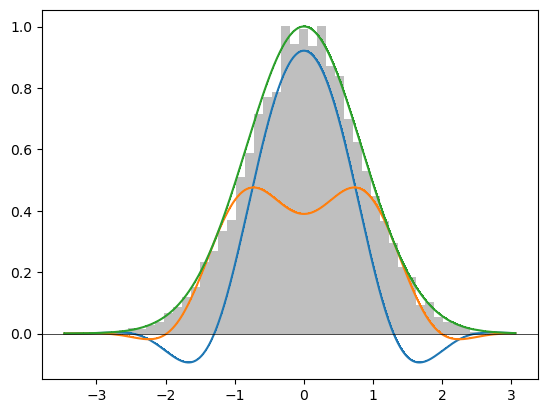

In [8]:
args = jnp.argsort(samples['x'])
x = samples['x'][args]
a = samples['amplitude'][args]
p = samples['phase'][args]

fig, ax = plt.subplots(1,1)
ax.plot(x, jnp.real(a*p), label='real', marker=',')
ax.plot(x, jnp.imag(a*p), label='imag', marker=',')
ax.plot(x, jnp.abs(a*p), label='abs', marker=',')
ax.axhline(0, color='black', linewidth=0.5)
h, b = jnp.histogram(samples['x'], bins=50); h*= a.max()/h.max()
plt.bar(0.5*(b[:-1]+b[1:]), h, width=b[1] - b[0], align='center', alpha=0.5, color='gray')
plt.show()

In [13]:
Z_pl = jnp.mean(samples['phase'])
Z_ana= (1.0+1j)*jnp.sqrt(jnp.pi/2)
print(f"PL : {Z_pl.real/Z_pl.imag} ")
print(f"Ana: {Z_ana.real/Z_ana.imag}")
# <- okay, the pahse is consistent with analytic result
# but... what should i do for normalization...

PL : 1.0150089263916016 
Ana: 1.0
